# Arabic Handwritten Recognition

## Overview
The automatic recognition of text on scanned images has enabled many applications such as searching for words in large volumes of documents, automatic sorting of postal mail, and convenient editing of previously printed documents.

The domain of handwriting in the Arabic script presents unique technical challenges and has been addressed more recently than other domains. Many different methods have been proposed and applied to various types of images.

Here we will focus on the recognition part of handwritten Arabic letters and digits recognition that face several challenges, including the unlimited variation in human handwriting and the large public databases.

In this project we will employ several deep learning models to classify a the images to an arabic letter or digit. 



## Dataset
The dataset for this project originates from kaggle kernels which include 
**[Arabic Digits](https://www.kaggle.com/mloey1/ahdd1)** and **[Arabic Letters](https://www.kaggle.com/mloey1/ahcd1)**.

All the datasets are CSV files representing the image pixels values and their corresponding label.

Here are some more details about the datasets:

* **Arabic Digits Dataset represents MADBase** (modified Arabic handwritten digits database) which contains **60,000 training images, and 10,000 test images**. MADBase was **written by 700 writers**. Each writer wrote each digit (from 0 -9) ten times. To ensure including different writing styles, the database was gathered from different institutions: Colleges of Engineering and Law, School of Medicine, the Open University (whose students span a wide range of ages), a high school, and a governmental institution. MADBase is available for free and can be downloaded from [here](http://datacenter.aucegypt.edu/shazeem/).

* **Arabic Letters Dataset is composed of 16,800 characters written by 60 participants**, the age range is between 19 to 40 years, and 90% of participants are right-hand. Each participant wrote each character (from ’alef’ to ’yeh’) ten times. The images were scanned at the resolution of 300 dpi. Each block is segmented automatically using Matlab 2016a to determining the coordinates for each block. **The dataset is partitioned into two sets: a training set of 13,440 characters to 480 images per class and a test set of 3,360 characters to 120 images per class**. Writers of training set and test set are exclusive. Ordering of including writers to test set are randomized to make sure that writers of test set are not from a single institution to ensure variability of the test set.

## Data Exploration


1. We need to mount to google drive to be able to use the uploaded dataset files.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2. Import libraries necessary for this project.


In [0]:
# Import main libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

# Import libraries needed for reading image and processing it
import csv
from PIL import Image
from scipy.ndimage import rotate

# Pretty display for notebooks
%matplotlib inline

3. Load the dataset files into dataframes to be used later in the project

### Loading Arabic Letters Dataset

In [4]:
# Training letters images and labels files
letters_training_images_file_path = "drive/My Drive/Capstone Project/Datasets 64x64/Arabic Handwritten Characters Dataset CSV/training images.zip"
letters_training_labels_file_path = "drive/My Drive/Capstone Project/Datasets 64x64/Arabic Handwritten Characters Dataset CSV/training labels.zip"
# Testing letters images and labels files
letters_testing_images_file_path = "drive/My Drive/Capstone Project/Datasets 64x64/Arabic Handwritten Characters Dataset CSV/testing images.zip"
letters_testing_labels_file_path = "drive/My Drive/Capstone Project/Datasets 64x64/Arabic Handwritten Characters Dataset CSV/testing labels.zip"

# Loading dataset into dataframes
training_letters_images = pd.read_csv(letters_training_images_file_path, compression='zip', header=None)
training_letters_labels = pd.read_csv(letters_training_labels_file_path, compression='zip', header=None)
testing_letters_images = pd.read_csv(letters_testing_images_file_path, compression='zip', header=None)
testing_letters_labels = pd.read_csv(letters_testing_labels_file_path, compression='zip', header=None)

# print statistics about the dataset
print("There are %d training arabic letter images of 64x64 pixels." %training_letters_images.shape[0])
print("There are %d testing arabic letter images of 64x64 pixels." %testing_letters_images.shape[0])
training_letters_images.head()

There are 13440 training arabic letter images of 64x64 pixels.
There are 3360 testing arabic letter images of 64x64 pixels.


,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Loading Arabic Digits Dataset

In [5]:
# Training digits images and labels files
digits_training_images_file_path = "drive/My Drive/Capstone Project/Datasets 64x64/Arabic Handwritten Digits Dataset CSV/training images.zip"
digits_training_labels_file_path = "drive/My Drive/Capstone Project/Datasets 64x64/Arabic Handwritten Digits Dataset CSV/training labels.zip"
# Testing digits images and labels files
digits_testing_images_file_path = "drive/My Drive/Capstone Project/Datasets 64x64/Arabic Handwritten Digits Dataset CSV/testing images.zip"
digits_testing_labels_file_path = "drive/My Drive/Capstone Project/Datasets 64x64/Arabic Handwritten Digits Dataset CSV/testing labels.zip"

# Loading dataset into dataframes
training_digits_images = pd.read_csv(digits_training_images_file_path, compression='zip', header=None)
training_digits_labels = pd.read_csv(digits_training_labels_file_path, compression='zip', header=None)
testing_digits_images = pd.read_csv(digits_testing_images_file_path, compression='zip', header=None)
testing_digits_labels = pd.read_csv(digits_testing_labels_file_path, compression='zip', header=None)

# print statistics about the dataset
print("There are %d training arabic digit images of 64x64 pixels." %training_digits_images.shape[0])
print("There are %d testing arabic digit images of 64x64 pixels." %testing_digits_images.shape[0])

There are 60000 training arabic digit images of 64x64 pixels.
There are 10000 testing arabic digit images of 64x64 pixels.


### Convert csv values to an image 
Writting a method to be used later if we want visualization of an image from its pixels values.

In [0]:
def convert_values_to_image(image_values, display=False):
  image_array = np.asarray(image_values)
  image_array = image_array.reshape(64, 64).astype('uint8')
  # The original dataset is reflected so we will flip it then rotate for a better view only.
  image_array = np.flip(image_array, 0)
  image_array = rotate(image_array, -90)
  new_image = Image.fromarray(image_array)
  if display == True:
    new_image.show()
  return new_image

### Visualizing some examples

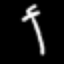

In [7]:
convert_values_to_image(training_letters_images.loc[0], True)

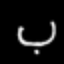

In [8]:
convert_values_to_image(training_letters_images.loc[12], True)

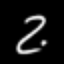

In [9]:
convert_values_to_image(training_letters_images.loc[37], True)

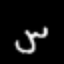

In [10]:
convert_values_to_image(training_letters_images.loc[3000], True)

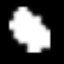

In [11]:
convert_values_to_image(training_digits_images.loc[0], True)

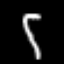

In [12]:
convert_values_to_image(training_digits_images.loc[2], True)

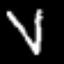

In [13]:
convert_values_to_image(training_digits_images.loc[7], True)

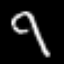

In [14]:
convert_values_to_image(training_digits_images.loc[9], True)

## Data Preprocessing

### Image Normalization
We rescale the images by dividing every pixel in the image by 255 to make them into range [0, 1]

In [0]:
training_digits_images_scaled = training_digits_images.values.astype('float32')/255
training_digits_labels = training_digits_labels.values.astype('int32')
testing_digits_images_scaled = testing_digits_images.values.astype('float32')/255
testing_digits_labels = testing_digits_labels.values.astype('int32')

training_letters_images_scaled = training_letters_images.values.astype('float32')/255
training_letters_labels = training_letters_labels.values.astype('int32')
testing_letters_images_scaled = testing_letters_images.values.astype('float32')/255
testing_letters_labels = testing_letters_labels.values.astype('int32')

In [16]:
print("Training images of digits after scaling")
print(training_digits_images_scaled.shape)
training_digits_images_scaled[0:5]

Training images of digits after scaling
(60000, 4096)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
print("Training images of letters after scaling")
print(training_letters_images_scaled.shape)
training_letters_images_scaled[0:5]

Training images of letters after scaling
(13440, 4096)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Encoding Categorical Labels
From the labels csv files we can see that labels are categorical values and it is a multi-class classification problem. 

Our outputs are in the form of:
* Digits from 0 to 9 have categories numbers from 0 to 9
* Letters from ’alef’ to ’yeh’ have categories numbers from 10 to 37

**Here we will encode these categories values using One Hot Encoding with keras.**

One-hot encoding transforms integer to a binary matrix where the array contains only one ‘1’ and the rest elements are ‘0’.



In [0]:
from keras.utils import to_categorical

# one hot encoding
# number of classes = 10 (digits classes) + 28 (arabic alphabet classes)
number_of_classes = 38
training_letters_labels_encoded = to_categorical(training_letters_labels, num_classes=number_of_classes)
testing_letters_labels_encoded = to_categorical(testing_letters_labels, num_classes=number_of_classes)
training_digits_labels_encoded = to_categorical(training_digits_labels, num_classes=number_of_classes)
testing_digits_labels_encoded = to_categorical(testing_digits_labels, num_classes=number_of_classes)

In [19]:
print(training_digits_labels_encoded)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Reshaping Input Images to 64x64x1


When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape
(nb_samples,rows,columns,channels)

where nb_samples corresponds to the total number of images (or samples), and rows, columns, and channels correspond to the number of rows, columns, and channels for each image, respectively.

**So we will reshape the input images to a 4D tensor with shape
(nb_samples, 64, 64 ,1)** as we use grayscale images of 64x64 pixels.

In [20]:
# reshape input digit images to 64x64x1
training_digits_images_scaled = training_digits_images_scaled.reshape([-1, 64, 64, 1])
testing_digits_images_scaled = testing_digits_images_scaled.reshape([-1, 64, 64, 1])

# reshape input letter images to 64x64x1
training_letters_images_scaled = training_letters_images_scaled.reshape([-1, 64, 64, 1])
testing_letters_images_scaled = testing_letters_images_scaled.reshape([-1, 64, 64, 1])

print(training_digits_images_scaled.shape, training_digits_labels_encoded.shape, testing_digits_images_scaled.shape, testing_digits_labels_encoded.shape)
print(training_letters_images_scaled.shape, training_letters_labels_encoded.shape, testing_letters_images_scaled.shape, testing_letters_labels_encoded.shape)

(60000, 64, 64, 1) (60000, 38) (10000, 64, 64, 1) (10000, 38)
(13440, 64, 64, 1) (13440, 38) (3360, 64, 64, 1) (3360, 38)


### Merging Letters and Digits Datasets

In [21]:
training_data_images = np.concatenate((training_digits_images_scaled, training_letters_images_scaled), axis=0) 
training_data_labels = np.concatenate((training_digits_labels_encoded, training_letters_labels_encoded), axis=0)
print("Total Training images are {} images of shape".format(training_data_images.shape[0]))
print(training_data_images.shape, training_data_labels.shape)


testing_data_images = np.concatenate((testing_digits_images_scaled, testing_letters_images_scaled), axis=0) 
testing_data_labels = np.concatenate((testing_digits_labels_encoded, testing_letters_labels_encoded), axis=0)
print("Total Testing images are {} images of shape".format(testing_data_images.shape[0]))
print(testing_data_images.shape, testing_data_labels.shape)


Total Training images are 73440 images of shape
(73440, 64, 64, 1) (73440, 38)
Total Testing images are 13360 images of shape
(13360, 64, 64, 1) (13360, 38)


## Designing Model Architecture

Now we will make a method which creates the model architecture with the specified optimizer and activation functions.

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense

def create_model(optimizer='adam', kernel_initializer='he_normal', activation='relu'):
  # create model
  model = Sequential()
  model.add(Conv2D(filters=16, kernel_size=3, padding='same', input_shape=(64, 64, 1), kernel_initializer=kernel_initializer, activation=activation))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=32, kernel_size=3, padding='same', kernel_initializer=kernel_initializer, activation=activation))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=64, kernel_size=3, padding='same', kernel_initializer=kernel_initializer, activation=activation))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=128, kernel_size=3, padding='same', kernel_initializer=kernel_initializer, activation=activation))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.2))
  model.add(GlobalAveragePooling2D())
  
  #Fully connected final layer
  model.add(Dense(38, activation='softmax'))

  # Compile model
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
  return model

Let’s understand above code step by step.

* The first hidden layer is a convolutional layer. The layer has 16 feature maps, which with the size of 3×3 and an activation function which is relu. This is the input layer, expecting images with the structure outlined above.
* The second layer is Batch Normalization which solves having distributions of the features vary across the training and test data, which breaks the IID assumption. We use it to help in two ways faster learning and higher overall accuracy. 
* The third layer is the MaxPooling layer. MaxPooling layer is used to down-sample the input to enable the model to make assumptions about the features so as to reduce overfitting. It also reduces the number of parameters to learn, reducing the training time.
* The next layer is a Regularization layer using dropout. It is configured to randomly exclude 20% of neurons in the layer in order to reduce overfitting.
* Another hidden layer with 32 feature maps with the size of 3×3 and a relu activation function to capture more features from the image.
* Other hidden layers with 64 and 128 feature maps with the size of 3×3 and a relu activation function to capture complex patterns from the image which will decribe the digits and letters later.
* More MaxPooling, Batch Normalization, Regularization and GlobalAveragePooling2D layers.
* The last layer is the output layer with 10 neurons (number of output classes) and it uses softmax activation function as we have multi-classes. Each neuron will give the probability of that class.

I used categorical_crossentropy as a loss function because its a multi-class classification problem. I used accuracy as metrics to improve the performance of our neural network.

## Model Summary And Visualization

Let's see the model summary.

In [23]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
__________

Keras support plotting the model in keras.utils.vis_utils module which provides utility functions to plot a Keras model using graphviz.

To be able to use that utility we should first install pydot and graphviz modules. This can be done by running the following code cell then restart the runtime environment.

In [24]:
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install -q pydot
import pydot

Selecting previously unselected package fontconfig.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../00-fontconfig_2.11.94-0ubuntu2_amd64.deb ...
Unpacking fontconfig (2.11.94-0ubuntu2) ...
Selecting previously unselected package libjbig0:amd64.
Preparing to unpack .../01-libjbig0_2.1-3.1_amd64.deb ...
Unpacking libjbig0:amd64 (2.1-3.1) ...
Selecting previously unselected package libcdt5.
Preparing to unpack .../02-libcdt5_2.38.0-16ubuntu2_amd64.deb ...
Unpacking libcdt5 (2.38.0-16ubuntu2) ...
Selecting previously unselected package libcgraph6.
Preparing to unpack .../03-libcgraph6_2.38.0-16ubuntu2_amd64.deb ...
Unpacking libcgraph6 (2.38.0-16ubuntu2) ...
Selecting previously unselected package libtiff5:amd64.
Preparing to unpack .../04-libtiff5_4.0.8-5ubuntu0.1_amd64.deb ...
Unpacking libtiff5:amd64 (4.0.8-5ubuntu0.1) ...
Selecting previously unselected package libwebp6:amd64.
Preparing to unpack .../05-libwebp6_0.6.0-3_amd64.deb ...
Unpa

Now we can plot the model and save it to a file also.

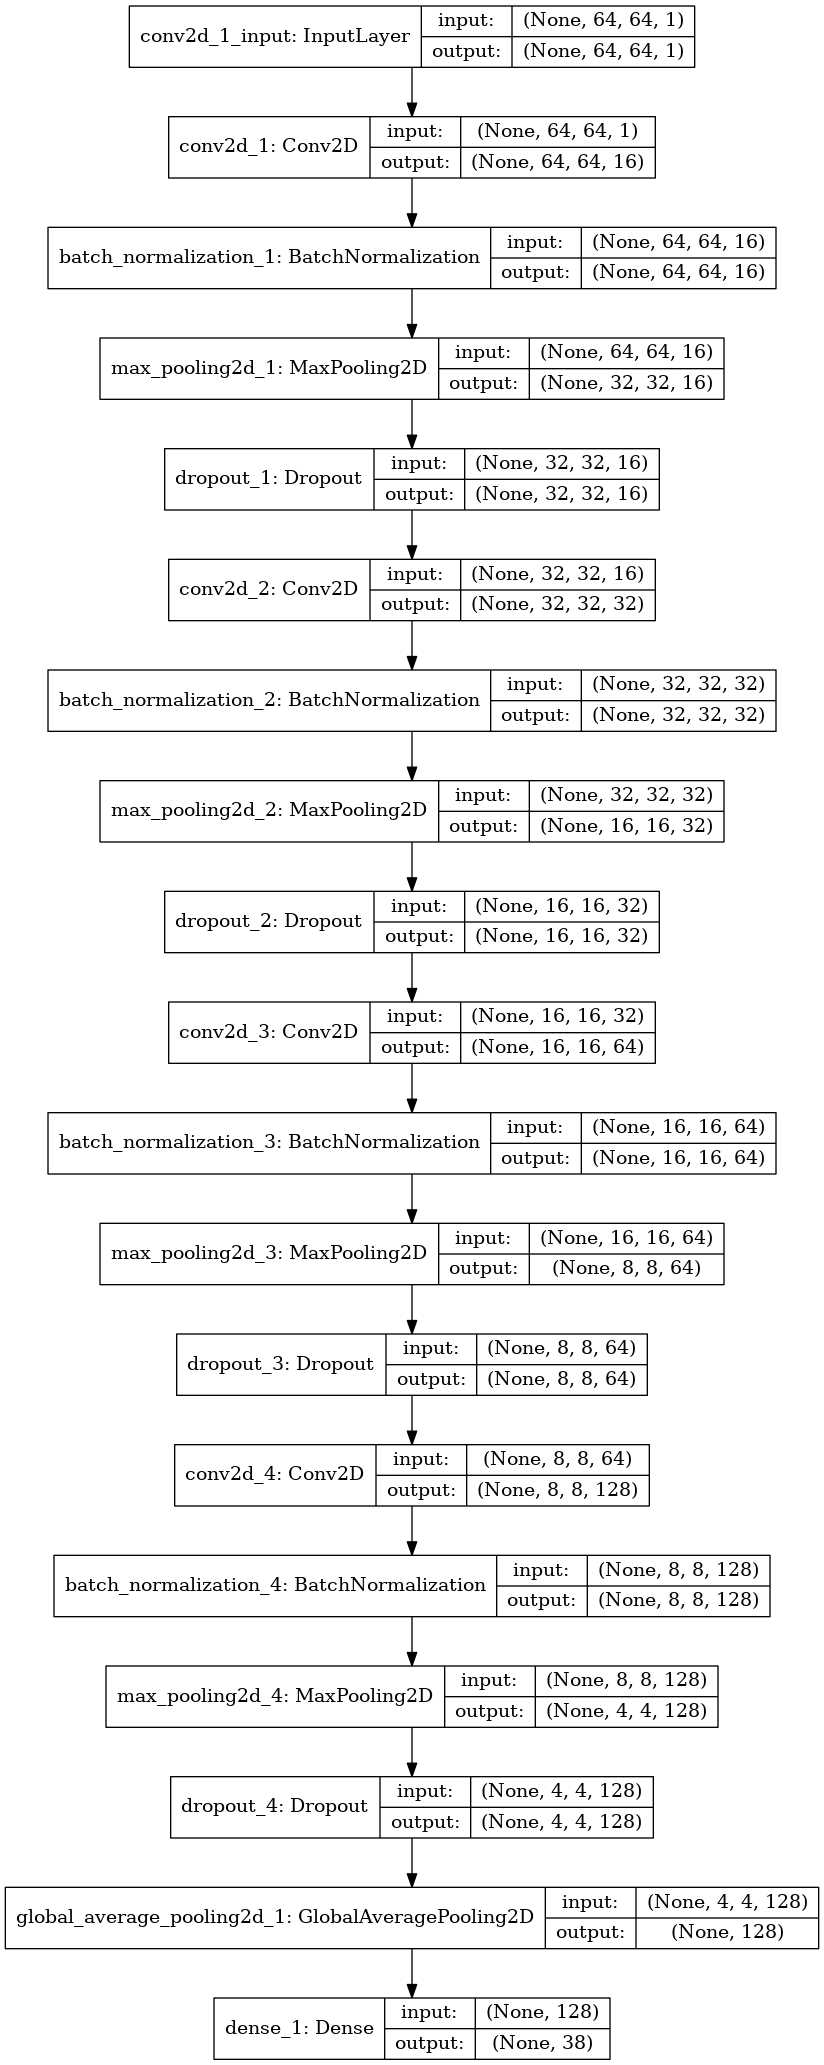

In [24]:
from keras.utils import plot_model

plot_model(model, to_file="model.png", show_shapes=True)
from IPython.display import Image as IPythonImage
display(IPythonImage('model.png'))

## Parameters Tuning

We will tune the parameters optimizer, kernel_initializer and activation.

In [25]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# define the grid search parameters
optimizer = ['RMSprop', 'Adam', 'Adagrad', 'Nadam']
kernel_initializer = ['normal', 'uniform']
activation = ['relu', 'linear', 'tanh']

param_grid = dict(optimizer=optimizer, kernel_initializer=kernel_initializer, activation=activation)

# count number of different parameters values combinations
parameters_number = 1
for x in param_grid:
  parameters_number = parameters_number * len(param_grid[x]) 
print("Number of different parameter combinations = {}".format(parameters_number))

Number of different parameter combinations = 24


We will try different models with different parameters to find the best parameter values.

In [26]:
epochs = 5
batch_size = 20 # 20 divides the training data samples

#creating the models with different hyperparameters
for a,b,c in [(x,y,z) for x in optimizer for z in activation for y in kernel_initializer]:
    params = {'optimizer' : a , 'kernel_initializer' : b , 'activation' : c}
    print(params)
    curr_model = create_model(a, b, c)
    curr_model.fit(training_data_images, training_data_labels, 
                    validation_data=(testing_data_images, testing_data_labels),
                    epochs=epochs, batch_size=batch_size, verbose=1)
    print("=============================================================================")

{'optimizer': 'RMSprop', 'kernel_initializer': 'normal', 'activation': 'relu'}
Train on 73440 samples, validate on 13360 samples
Epoch 1/5
73440/73440 [==============================] - 84s 1ms/step - loss: 0.3349 - acc: 0.9089 - val_loss: 2.4386 - val_acc: 0.5037
Epoch 2/5
73440/73440 [==============================] - 82s 1ms/step - loss: 0.1106 - acc: 0.9670 - val_loss: 0.1605 - val_acc: 0.9507
Epoch 3/5
73440/73440 [==============================] - 81s 1ms/step - loss: 0.0865 - acc: 0.9738 - val_loss: 0.1138 - val_acc: 0.9665
Epoch 4/5
73440/73440 [==============================] - 81s 1ms/step - loss: 0.0788 - acc: 0.9772 - val_loss: 2.5557 - val_acc: 0.5233
Epoch 5/5
73440/73440 [==============================] - 81s 1ms/step - loss: 0.0710 - acc: 0.9788 - val_loss: 0.1519 - val_acc: 0.9559
{'optimizer': 'RMSprop', 'kernel_initializer': 'uniform', 'activation': 'relu'}
Train on 73440 samples, validate on 13360 samples
Epoch 1/5
73440/73440 [==============================] - 83s 

**From the above results we can see that best parameters are:**
* **Optimizer: Adam**
* **Kernel_initializer: uniform**
* **Activation: relu** 

Let's create the model with the best parameters obtained.

In [0]:
model = create_model(optimizer='Adam', kernel_initializer='uniform', activation='relu')

## Training the Model


### Fitting the Model

Train the model using batch_size=20 to reduce used memory and make the training more quick.
We will train the model first on 10 epochs to see the accuracy that we will obtain.

In [31]:
from keras.callbacks import ModelCheckpoint  

# using checkpoints to save model weights to be used later instead of training again on the same epochs.
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)
history = model.fit(training_data_images, training_data_labels, 
                    validation_data=(testing_data_images, testing_data_labels),
                    epochs=10, batch_size=20, verbose=1, callbacks=[checkpointer])

Train on 73440 samples, validate on 13360 samples
Epoch 1/10
73440/73440 [==============================] - 94s 1ms/step - loss: 0.3189 - acc: 0.9153 - val_loss: 10.5339 - val_acc: 0.1437

Epoch 00001: val_loss improved from inf to 10.53390, saving model to weights.hdf5
Epoch 2/10
73440/73440 [==============================] - 89s 1ms/step - loss: 0.1049 - acc: 0.9681 - val_loss: 0.3283 - val_acc: 0.9012

Epoch 00002: val_loss improved from 10.53390 to 0.32826, saving model to weights.hdf5
Epoch 3/10
73440/73440 [==============================] - 90s 1ms/step - loss: 0.0797 - acc: 0.9757 - val_loss: 0.6523 - val_acc: 0.7985

Epoch 00003: val_loss did not improve from 0.32826
Epoch 4/10
73440/73440 [==============================] - 89s 1ms/step - loss: 0.0702 - acc: 0.9782 - val_loss: 0.2071 - val_acc: 0.9394

Epoch 00004: val_loss improved from 0.32826 to 0.20706, saving model to weights.hdf5
Epoch 5/10
73440/73440 [==============================] - 89s 1ms/step - loss: 0.0592 - acc: 

### Plotting Loss and Accuracy Curves with Epochs

In [0]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(history):
  # Loss Curves
  plt.figure(figsize=[8,6])
  plt.plot(history.history['loss'],'r',linewidth=3.0)
  plt.plot(history.history['val_loss'],'b',linewidth=3.0)
  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)

  # Accuracy Curves
  plt.figure(figsize=[8,6])
  plt.plot(history.history['acc'],'r',linewidth=3.0)
  plt.plot(history.history['val_acc'],'b',linewidth=3.0)
  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16) 

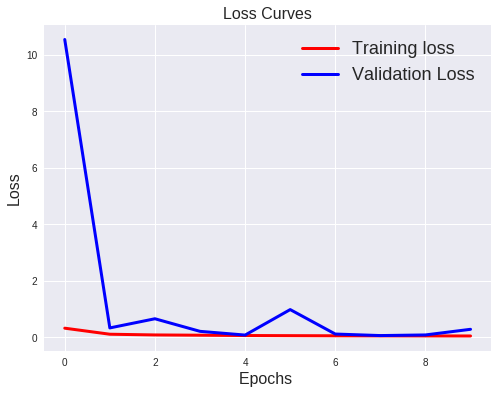

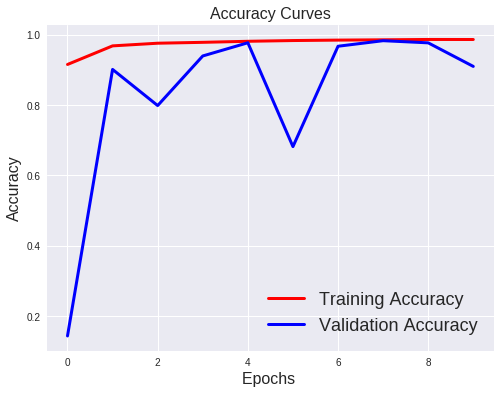

In [36]:
plot_loss_accuracy(history)

### Load the Model with the Best Validation Loss


In [0]:
model.load_weights('weights.hdf5')

## Test the Model


In [38]:
# Final evaluation of the model
metrics = model.evaluate(testing_data_images, testing_data_labels, verbose=1)
print("Test Accuracy: {}".format(metrics[1]))
print("Test Loss: {}".format(metrics[0]))

13360/13360 [==============================] - 5s 343us/step
Test Accuracy: 0.9828592814371258
Test Loss: 0.05756271482567684


**We get test accuracy of 98.286% after training on 10 epochs only.**

**What about increasing the epochs we train on ?**

## Training More on the best model

Train on 73440 samples, validate on 13360 samples
Epoch 1/20
73440/73440 [==============================] - 89s 1ms/step - loss: 0.0447 - acc: 0.9859 - val_loss: 0.4244 - val_acc: 0.8557

Epoch 00001: val_loss improved from inf to 0.42443, saving model to weights.hdf5
Epoch 2/20
73440/73440 [==============================] - 89s 1ms/step - loss: 0.0414 - acc: 0.9863 - val_loss: 0.0576 - val_acc: 0.9830

Epoch 00002: val_loss improved from 0.42443 to 0.05760, saving model to weights.hdf5
Epoch 3/20
73440/73440 [==============================] - 89s 1ms/step - loss: 0.0396 - acc: 0.9872 - val_loss: 0.0546 - val_acc: 0.9844

Epoch 00003: val_loss improved from 0.05760 to 0.05457, saving model to weights.hdf5
Epoch 4/20
73440/73440 [==============================] - 89s 1ms/step - loss: 0.0400 - acc: 0.9875 - val_loss: 0.4204 - val_acc: 0.8711

Epoch 00004: val_loss did not improve from 0.05457
Epoch 5/20
73440/73440 [==============================] - 89s 1ms/step - loss: 0.0367 - acc: 0.9

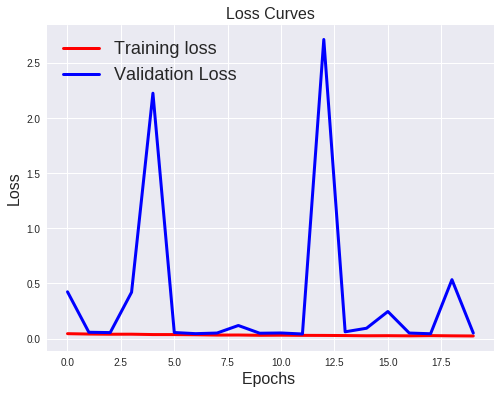

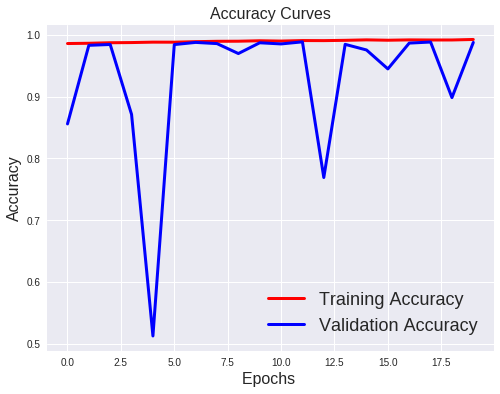

In [39]:
epochs = 20
batch_size = 20

checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)

history = model.fit(training_data_images, training_data_labels, 
                    validation_data=(testing_data_images, testing_data_labels),
                    epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[checkpointer])
          
model.load_weights('weights.hdf5')
plot_loss_accuracy(history)

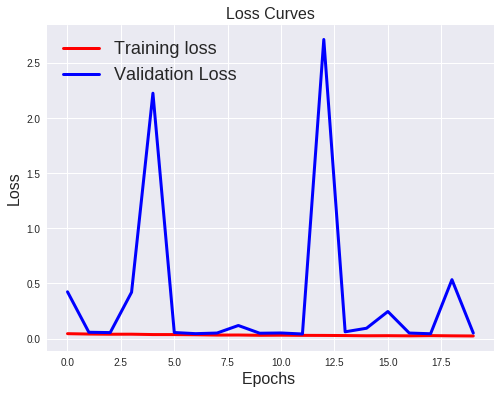

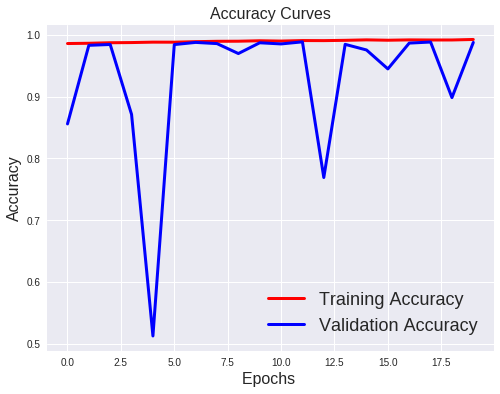

In [41]:
plot_loss_accuracy(history)

## Testing the Model again

In [40]:
# Final evaluation of the model
metrics = model.evaluate(testing_data_images, testing_data_labels, verbose=1)
print("Test Accuracy: {}".format(metrics[1]))
print("Test Loss: {}".format(metrics[0]))

13360/13360 [==============================] - 5s 346us/step
Test Accuracy: 0.988622754491018
Test Loss: 0.04191313635113142


After training the model on more epochs we gained a better model which can classify complex patterns . So when we tested it on our test dataset we had better results than before.

**Test accuracy is improved from 98.286% to 98.862% As we train the model on 20 more epochs.**



## Saving the Final Model

Let's save the model on json format to be used later instead of creating the model again from scratch.

In [0]:
from keras.models import model_from_yaml
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

Save the model weights to file.

In [46]:
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


if we want to load the model with the last obtained weights at anytime, we will run the following code cell.

In [47]:
# load YAML and create model
yaml_file = open('model.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# compile the loaded model
loaded_model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

Loaded model from disk


## Benchmark Model

We will use a very simple (vanilla) CNN model as benchmark and Train/test it using the same data that you have used for our model solution.
Then Compare the results between the vanilla model and our complex model.

In [55]:
baseline_model = Sequential()
baseline_model.add(Conv2D(filters=16, kernel_size=3, padding='same', input_shape=(64, 64, 1), activation='relu')) # Input layer
baseline_model.add(GlobalAveragePooling2D())
baseline_model.add(Dense(38, activation = 'softmax')) # Output layer => output dimension = 38 as it is multi-class

# Compile the baseline model
baseline_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='Adam')

# Fit the baseline model with training dataset
epochs = 5
batch_size = 20

baseline_model.fit(training_data_images, training_data_labels, 
                  validation_data=(testing_data_images, testing_data_labels),
                  epochs=epochs, batch_size=batch_size, verbose=1)

# Test the baseline model
baseline_metrics = baseline_model.evaluate(testing_data_images, testing_data_labels, verbose=1)
print("Baseline Model Test Accuracy: {}".format(baseline_metrics[1]))
print("Baseline Model Test Loss: {}".format(baseline_metrics[0]))


Train on 73440 samples, validate on 13360 samples
Epoch 1/5
73440/73440 [==============================] - 45s 619us/step - loss: 2.7163 - acc: 0.1814 - val_loss: 2.7079 - val_acc: 0.2183
Epoch 2/5
73440/73440 [==============================] - 40s 550us/step - loss: 2.4709 - acc: 0.2514 - val_loss: 2.6120 - val_acc: 0.2372
Epoch 3/5
73440/73440 [==============================] - 40s 549us/step - loss: 2.3945 - acc: 0.2754 - val_loss: 2.5453 - val_acc: 0.2608
Epoch 4/5
73440/73440 [==============================] - 41s 552us/step - loss: 2.3237 - acc: 0.3069 - val_loss: 2.4661 - val_acc: 0.2959
Epoch 5/5
13360/13360 [==============================] - 2s 175us/step
Baseline Model Test Accuracy: 0.32372754491017963
Baseline Model Test Loss: 2.376121672327647


**We get test accuracy of 32.37% from the baseline Model (vanilla). **

## Predict Image Classes

Making a method which takes a model, data and its true labels (optional for using in testing). Then it gives the predicted classes of the given data using the given model.

In [0]:
def get_predicted_classes(model, data, labels=None):
  image_predictions = model.predict(data)
  predicted_classes = np.argmax(image_predictions, axis=1)
  true_classes = np.argmax(labels, axis=1)
  return predicted_classes, true_classes

## Comparing Evaluation Metrics between Benchmark Model and Final Model

Making a method which will print all metrics (precision, recall, f1-score and support) with each class in the dataset.

In [0]:
from sklearn.metrics import classification_report

def get_classification_report(y_true, y_pred):
  print(classification_report(y_true, y_pred))

### Evaluating Final Model using the specified metrics

In [63]:
y_pred, y_true = get_predicted_classes(model, testing_data_images, testing_data_labels)
get_classification_report(y_true, y_pred)

             precision    recall  f1-score   support

          0       0.99      0.98      0.99      1000
          1       0.99      1.00      0.99      1000
          2       0.99      0.99      0.99      1000
          3       1.00      0.99      0.99      1000
          4       1.00      0.99      1.00      1000
          5       0.99      0.99      0.99      1000
          6       1.00      0.99      1.00      1000
          7       1.00      0.99      1.00      1000
          8       1.00      1.00      1.00      1000
          9       1.00      1.00      1.00      1000
         10       1.00      1.00      1.00       120
         11       1.00      1.00      1.00       120
         12       0.96      0.96      0.96       120
         13       0.98      0.99      0.98       120
         14       0.99      0.97      0.98       120
         15       0.97      0.99      0.98       120
         16       0.99      0.97      0.98       120
         17       0.96      0.94      0.95   

### Evaluating Baseline (Benchmark) Model using the specified metrics

In [65]:
y_pred, y_true = get_predicted_classes(baseline_model, testing_data_images, testing_data_labels)
get_classification_report(y_true, y_pred)

             precision    recall  f1-score   support

          0       0.95      0.84      0.89      1000
          1       0.25      0.90      0.39      1000
          2       0.29      0.23      0.26      1000
          3       0.24      0.28      0.25      1000
          4       0.31      0.29      0.30      1000
          5       0.52      0.73      0.61      1000
          6       0.18      0.37      0.24      1000
          7       0.28      0.64      0.39      1000
          8       0.00      0.00      0.00      1000
          9       0.16      0.03      0.04      1000
         10       0.00      0.00      0.00       120
         11       0.00      0.00      0.00       120
         12       0.00      0.00      0.00       120
         13       0.00      0.00      0.00       120
         14       0.00      0.00      0.00       120
         15       0.00      0.00      0.00       120
         16       0.00      0.00      0.00       120
         17       0.48      0.18      0.27   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Conclusion

**We built a CNN model which can classify the arabic handwritten images into digits and letters. We tested the model on more than 13000 image with all possible classes and got very high accuracy of 98.86%.**